In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pickle


# Model 1 - Logistic Regression - Identifying Probability of Home Team Winning/Losing Based on Home and Visiting Team Offensive and Defensive Stats During a Game

Since I am focused on model accuracy and finding the probability that the home team wins or loses based on team offensive and defensive stats, I am not concerned about the interpretation of the coefficients, and thus multicollinearity between the predictor variables is not an issue. 

But before I can run the model I need to prep the data by categorizing wins and losses by the home team, and use that as my target variable.

In [3]:
game_logs_home = pd.read_csv("../capstone/gl_csv/concat_game_logs.csv")

/var/folders/0b/5brsgfcj1659x_1js0_30dgm0000gn/T/ipykernel_25505/708457900.py:1: DtypeWarning: Columns (13,14,15,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  game_logs_home = pd.read_csv("../capstone/gl_csv/concat_game_logs.csv")


In [4]:
game_logs_home

,1 Date,2 Number of game,3 Day of week,4 Visiting team,5 Visiting team league,6 Visiting team game number,7 Home team,8 Home league,9 Home team game number,10 Visiting team score,...,152 home player 20,153 home player 21,154 home player 22,155 home player 23,156 home player 24,157 home player 25,158 home player 26,159 home player 27,160 Additional information,161 Acquisition information:
0,19520415.0,0.0,Tue,SLA,AL,1.0,DET,AL,1.0,3.0,...,Matt Batts,2.0,pridj101,Jerry Priddy,4.0,troud101,Dizzy Trout,1.0,NaN,Y
1,19520415.0,0.0,Tue,BOS,AL,1.0,WS1,AL,1.0,3.0,...,Clyde Kluttz,2.0,uptot101,Tom Upton,6.0,portb102,Bob Porterfield,1.0,NaN,Y
2,19520415.0,0.0,Tue,BRO,NL,1.0,BSN,NL,1.0,3.0,...,Eddie Mathews,5.0,cusij101,Jack Cusick,6.0,spahw101,Warren Spahn,1.0,NaN,Y
3,19520415.0,0.0,Tue,CHN,NL,1.0,CIN,NL,1.0,6.0,...,Andy Seminick,2.0,mcmir101,Roy McMillan,6.0,wehmh101,Herm Wehmeier,1.0,NaN,Y
4,19520415.0,0.0,Tue,PIT,NL,1.0,SLN,NL,1.0,2.0,...,Billy Johnson,5.0,riced101,Del Rice,2.0,stalg103,Gerry Staley,1.0,NaN,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146868,19721004.0,0.0,Wed,PHI,NL,156.0,CHN,NL,156.0,2.0,...,Bill North,8.0,hundr101,Randy Hundley,2.0,bonhb101,Bill Bonham,1.0,NaN,Y
146869,19721004.0,0.0,Wed,HOU,NL,153.0,CIN,NL,154.0,2.0,...,Dave Concepcion,6.0,plumb101,Bill Plummer,2.0,borbp101,Pedro Borbon,1.0,NaN,Y
146870,19721004.0,0.0,Wed,NYN,NL,156.0,MON,NL,156.0,3.0,...,Pepe Mangual,9.0,boccj101,John Boccabella,2.0,moorb101,Balor Moore,1.0,NaN,Y
146871,19721004.0,0.0,Wed,SLN,NL,156.0,PIT,NL,155.0,4.0,...,Jose Pagan,5.0,alleg101,Gene Alley,6.0,briln101,Nelson Briles,1.0,NaN,Y


In [5]:
# for loop to create a list of "W" and "L"; "W" (win) if the home team scores more than the visiting team, "L" (loss) of the 
# home team scores less than the visiting team.

results_list = []
count = 0
for x in game_logs_home["11 Home team score"]:
   
    if count <= len(game_logs_home["10 Visiting team score"]):
        if x > game_logs_home["10 Visiting team score"][count]:
            a = "W"
            results_list.append(a)
            count += 1
        elif x < game_logs_home["10 Visiting team score"][count]:
            b = "L"
            results_list.append(b)
            count += 1
        else:
            c = "T"
            results_list.append(c)
            count += 1

In [6]:
# Filling a new column game_log_home["results"] with values in results_list
game_logs_home["results"] = results_list

Using the home team win-loss record as the null model, the baseline accuracy is 53.8%. I will ignore the tied games signified by "T", by only counting the entries with either a "W" or "L".

In [7]:
game_logs_home = game_logs_home[game_logs_home["results"] != "T"]

In [8]:
game_logs_home["results"].value_counts(normalize = True)

W    0.53882
L    0.46118
Name: results, dtype: float64

Creating my X and y variables:

In [30]:
features = [          
 '23 visiting hits',
 '24 visiting doubles',
 '25 visiting triples',

 '30 visiting hit-by-pitch',
 '31 visiting walks',
 '32 visiting intentional walks',
 '33 visiting strikeouts',
 '34 visiting stolen bases',
 '35 visiting caught stealing',
 '36 visiting grounded into double plays',
 "37 visiting awarded first on catcher's interference",
 '38 visiting left on base',
 '39 visiting pitchers used',

 '42 visiting wild pitches',
 '43 visiting balks',
 
 '45 visiting assists',
 '46 visiting errors',
 '47 visiting passed balls',
 '48 visiting double plays',
 '49 visiting triple plays',
 '51 home hits',
 '52 home doubles',
 '53 home triples',
 
 '58 home hit-by-pitch',
 '59 home walks',
 '60 home intentional walks',
 '61 home strikeouts',
 '62 home stolen bases',
 '63 home caught stealing',
 '64 home grounded into double plays',
 "65 home awarded first on catcher's interference",
 '66 home left on base',
 '67 home pitchers used',
 
 '70 home wild pitches',
 '71 home balks',
 
 '73 home assists',
 '74 home errors',
 '75 home passed balls',
 '76 home double plays',
 '77 home triple plays', ]

X = game_logs_home[features]


y = game_logs_home["results"]

Train test split:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((110018, 40), (36673, 40), (110018,), (36673,))

Instantiating model

In [33]:
logreg_home = LogisticRegression(penalty = "none")

Fitting:

In [34]:
logreg_home.fit(X_train, y_train)

/Users/danielwong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

Scoring: 

- The training and testing accuracy rate of this model is 96%, with negligible difference between the two scores. 

In [35]:
logreg_home.score(X_train, y_train), logreg_home.score(X_test, y_test)

(0.9607427875438564, 0.9619065797725848)

# Model 2 - Logistic Regression -  What if I only used the following features in the model? How would this affect the model's accuracy?

home hit-by-pitch                                   
home hits                                           
home walks                                          
visiting left on base                               
visiting caught stealing                            
home double plays                                    
visiting errors                                      
                                                                    
home errors                                          
home caught stealing                                 
visiting double plays                                
visiting hit-by-pitch                                
visiting walks                                      
home left on base                                   
visiting hits              


In this model, the accuracy rate for both the training and test set was 95%, which is not a big difference from the first model, whose accuracy rate was 96%. Both models outperform the null model accuracy rate of 53.8%. I most likely will use Model 2 - logistic regression for the streamlit app because it has 14 predictor variables vs 40, and thus requires the user to input less information, while the accuracy rate only decreases by 1%, an acceptable tradeoff.

In [36]:
features = ["58 home hit-by-pitch",
"51 home hits",
"59 home walks",
"38 visiting left on base",
"35 visiting caught stealing",
"76 home double plays",
"46 visiting errors",
                         
"74 home errors" ,                            
"63 home caught stealing" ,                      
"48 visiting double plays" ,                          
"30 visiting hit-by-pitch" ,                          
"31 visiting walks" ,                        
"66 home left on base" ,                       
"23 visiting hits" ]

X = game_logs_home[features]

y = game_logs_home["results"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((110018, 14), (36673, 14), (110018,), (36673,))

In [39]:
logreg_home= LogisticRegression(penalty = "none")

In [40]:
logreg_home.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [41]:
logreg_home.score(X_train, y_train), logreg_home.score(X_test, y_test)

(0.9569524986820338, 0.9574346249284215)

# Model 2 - Logistic Regression GridSearch Pipeline to see if I can improve the accuracy rate

The grid search pipeline using various logistic regression max_iter parameter values did not improve the accuracy rate, which remained at 95%.

In [16]:
logreg_params = {
    'max_iter': [100, 200, 300],
    'n_jobs': [-1]
}

logreg_gridsearch = GridSearchCV(LogisticRegression(), # What is the model we want to fit?
                              logreg_params, # What is the dictionary of hyperparameters?
                              cv = 5, # What number of folds in CV will we use?
                              ) 

In [17]:
logreg_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 200, 300], 'n_jobs': [-1]})

In [18]:
logreg_gridsearch.score(X_test, y_test)

0.9573800888937365

In [20]:
logreg_gridsearch.best_score_

0.9568343401438135

In [19]:
logreg_gridsearch.best_params_

{'max_iter': 100, 'n_jobs': -1}

# Model 3 - Stacked Model

Using a stacked model with random forest, gradient boost, and ada boost as level 1 estimators, and a logistic regression as the final estimator gave me an accuracy score of 89% for the test set and 99% for the training set, indicating this is a model that suffers from overfitting, and is generally worse performing than the model-2 logistic regression model that I previously ran, which had an accuracy rate of 95% for both the testing and training set.

In [21]:
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model.fit(X_train, y_train)
stacked_model.score(X_test, y_test)

0.8941728246939165

In [22]:
stacked_model.score(X_train,y_train)

0.9990001636095912

# If I was to create a Logistic Regression model that minimized multicollinearity in the predictor variables, I'd probably use the model below. 

Note this model, which left out the predictor variables "home left on base" and "visitor left on base", has a training and test set accuracy rate of 81%, lower than the previous models, but the Variance Inflation Factors scores for each predictor variable is much lower, which makes the the coefficients more interpretable.
For example:

- For every error by the visiting team, the home team is 1.4 times more likely to win.

- For every double play by the home team, the home team in 1.4 times more likely to win.


In [94]:
features = ["58 home hit-by-pitch",
"51 home hits",
"59 home walks",
"35 visiting caught stealing",
"76 home double plays",
"46 visiting errors",
                         
"74 home errors" ,                            
"63 home caught stealing" ,                      
"48 visiting double plays" ,                          
"30 visiting hit-by-pitch" ,                          
"31 visiting walks" ,                        
                       
"23 visiting hits" ]

X = game_logs_home[features]

y = game_logs_home["results"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [96]:
logreg_home= LogisticRegression(penalty = "none")

In [97]:
logreg_home.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [98]:
logreg_home.score(X_train, y_train), logreg_home.score(X_test, y_test)

(0.8126579287025759, 0.8172497477708396)

In [111]:
# function from DSI instructor Devin Fay's linear regression lesson

def calc_vif(data):
    v_df = pd.DataFrame(columns = ['vif'],
                       index = data.columns)
    
    v_df['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    
    return v_df.sort_values(by = 'vif', ascending = False)

Variance Inflation Scores. Note they are still a bit high but much lower than previous iterations with other predictor variable combinations.

In [77]:
calc_vif(X_train)

,vif
23 visiting hits,6.466515
51 home hits,6.455305
59 home walks,3.421888
31 visiting walks,3.375998
76 home double plays,2.034977
48 visiting double plays,1.977248
74 home errors,1.725081
46 visiting errors,1.715042
35 visiting caught stealing,1.294459
63 home caught stealing,1.263404


In [78]:
np.exp(logreg_home.coef_)[0]

array([1.36664482, 1.56209439, 1.32774852, 0.95460558, 1.39764588,
       1.41563887, 0.6734081 , 1.04830667, 0.66977203, 0.69700904,
       0.73021219, 0.61872861])

In [79]:
logreg_home_coef_df = pd.DataFrame(np.exp(logreg_home.coef_)[0], index = X_test.columns, columns = ['Coefficient'])

In [80]:
logreg_home_coef_df["Coefficient"].sort_values(ascending = False)

51 home hits                   1.562094
46 visiting errors             1.415639
76 home double plays           1.397646
58 home hit-by-pitch           1.366645
59 home walks                  1.327749
63 home caught stealing        1.048307
35 visiting caught stealing    0.954606
31 visiting walks              0.730212
30 visiting hit-by-pitch       0.697009
74 home errors                 0.673408
48 visiting double plays       0.669772
23 visiting hits               0.618729
Name: Coefficient, dtype: float64

# Model 2 Evaluation - Logistic Regression

Based on the confusion matrix below, model 2, with an accuracy of 95% (for both the train and test sets), produced slightly more false positives (727) than false negatives (834), but not by much.

In [55]:
preds = logreg_home.predict(X_test)

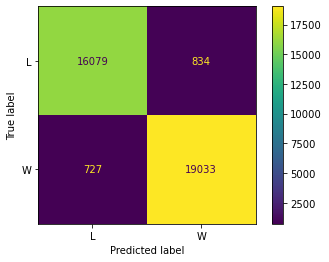

In [56]:
ConfusionMatrixDisplay.from_estimator(logreg_home, X_test, y_test);

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn, fp, fn, tp

(16079, 834, 727, 19033)

In [58]:
recall = tp/(tp+fn)

precision = tp/(tp+fp)

f1_test = 2 * (precision*recall) / (precision+recall)

accuracy = (tp+tn) / (tp+tn+fp+fn)

misclass = 1 - accuracy

print(f"Recall is {recall}")

print(f"Precision is {precision}")

print(f"F1 score is {f1_test}")

print(f"Accuracy is {accuracy}")

print(f"Misclassification rate is {misclass}")


Recall is 0.9632085020242915
Precision is 0.958020838576534
F1 score is 0.9606076664900194
Accuracy is 0.9574346249284215
Misclassification rate is 0.04256537507157854


# Examining the instances in which the Model 2 misclassified the data

In [42]:
game_logs_home["preds"] = logreg_home.predict(X)
logreg_model2_incorrect = game_logs_home[game_logs_home["preds"] != game_logs_home["results"]]

/var/folders/0b/5brsgfcj1659x_1js0_30dgm0000gn/T/ipykernel_25505/909321114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_logs_home["preds"] = logreg_home.predict(X)


There were 6297 games in which the model misclassified the results. Since the model examined 146,691 total games, this comes out to a 4.3% misclassification rate.

In [54]:
len(logreg_model2_incorrect)

6297

Looking at the descriptive statistics of the games that the model misclassified, the average of value for each predictor variable associated with the home and visiting team were very close. For example:

Model misclassified games in which the home and visiting team had the same or very similar values for the predictor variables.

In [66]:
logreg_model2_incorrect[[
 
"58 home hit-by-pitch",
"30 visiting hit-by-pitch" , 
    
"51 home hits",
"23 visiting hits",

"59 home walks",
"31 visiting walks" ,

"66 home left on base" ,                       
"38 visiting left on base",

"76 home double plays",
"48 visiting double plays" , 

"74 home errors" , 
"46 visiting errors",

"63 home caught stealing" ,
"35 visiting caught stealing",

"11 Home team score",
"10 Visiting team score",

"results",
"preds"]].sample(5)

,58 home hit-by-pitch,30 visiting hit-by-pitch,51 home hits,23 visiting hits,59 home walks,31 visiting walks,66 home left on base,38 visiting left on base,76 home double plays,48 visiting double plays,74 home errors,46 visiting errors,63 home caught stealing,35 visiting caught stealing,11 Home team score,10 Visiting team score,results,preds
142325,0.0,0.0,7.0,6.0,1.0,4.0,5.0,8.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,W,L
119256,1.0,0.0,7.0,7.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,4.0,5.0,L,W
110,0.0,0.0,7.0,6.0,3.0,2.0,8.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,L,W
121254,0.0,0.0,18.0,10.0,8.0,3.0,19.0,5.0,3.0,1.0,1.0,0.0,1.0,1.0,4.0,5.0,L,W
86289,0.0,0.0,9.0,7.0,1.0,7.0,7.0,10.0,1.0,1.0,1.0,4.0,1.0,0.0,3.0,4.0,L,W


# Of the games the model misclassified, what percentage of the games had a margin or victory of one run for either team?

90% of the games the model misclassified had a margin of victory of one run for either team. This suggests the model had a hard time accurately classifying whether the home team won or lose in close games.

Created a new column that contains the absolute value of the run differential between the home team score and the visiting team score to determine the margin of victory for each game.

In [62]:
logreg_model2_incorrect["run_diff_bet_home_visiting"] = abs(logreg_model2_incorrect["10 Visiting team score"] - logreg_model2_incorrect["11 Home team score"])

/var/folders/0b/5brsgfcj1659x_1js0_30dgm0000gn/T/ipykernel_25505/2924366867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logreg_model2_incorrect["run_diff_bet_home_visiting"] = abs(logreg_model2_incorrect["10 Visiting team score"] - logreg_model2_incorrect["11 Home team score"])


In [65]:
logreg_model2_incorrect["run_diff_bet_home_visiting"].value_counts(normalize = True).sort_values(ascending = False)

1.0    0.905669
2.0    0.085120
3.0    0.008417
4.0    0.000794
Name: run_diff_bet_home_visiting, dtype: float64

# What was the most common margin of victory? What was the model's misclassfication rate for games with a margin of victory of one-run for either team?

The most common margin of victory was one-run, with 30% of the games fitting this criteria, followed by two-run margin of victory which made up 18% of games. The model's misclass rate for games with a margin of victory of one-run for either team is 13%

In [70]:
game_logs_home["run_diff_bet_home_visiting"] = abs(game_logs_home["10 Visiting team score"] - game_logs_home["11 Home team score"])

/var/folders/0b/5brsgfcj1659x_1js0_30dgm0000gn/T/ipykernel_25505/2974959519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_logs_home["run_diff_bet_home_visiting"] = abs(game_logs_home["10 Visiting team score"] - game_logs_home["11 Home team score"])


In [102]:
game_logs_home["run_diff_bet_home_visiting"].value_counts().head()

1.0    43872
2.0    27111
3.0    21402
4.0    16466
5.0    11928
Name: run_diff_bet_home_visiting, dtype: int64

In [93]:
one_run_marg_vict = game_logs_home[game_logs_home["run_diff_bet_home_visiting"] == 1]

In [94]:
one_run_marg_vict_misclass = one_run_marg_vict[one_run_marg_vict["preds"] != one_run_marg_vict["results"]]

In [162]:
a = len(one_run_marg_vict_misclass) / len(one_run_marg_vict)

In [163]:
a = round(a*100)

In [164]:
a

13

# What was the model's misclassfication rate for games with a margin of victory of two-runs for either team?

The model's misclass rate for games with a margin of victory of one-run for either team is 2%.

In [127]:
two_run_marg_vict = game_logs_home[game_logs_home["run_diff_bet_home_visiting"] == 2]

In [128]:
two_run_marg_vict_misclass = two_run_marg_vict[two_run_marg_vict["preds"] != two_run_marg_vict["results"]]

In [171]:
b = len(two_run_marg_vict_misclass) / len(two_run_marg_vict)

In [172]:
b = round(b*100)

In [173]:
b

2

# What was the model's misclassfication rate for games with a margin of victory of three-runs for either team?

In [188]:
three_run_marg_vict = game_logs_home[game_logs_home["run_diff_bet_home_visiting"] == 3]

In [189]:
three_run_marg_vict_misclass = three_run_marg_vict[three_run_marg_vict["preds"] != three_run_marg_vict["results"]]

In [190]:
c = len(three_run_marg_vict_misclass) / len(three_run_marg_vict)

In [192]:
c = round(c*100)

Putting the misclassification rate values for games with one-run, two-run, and three-run margins of victory into the dataframe so that I can plot it in a bar graph.

In [193]:
misclass_rate = [a, b, c]

In [194]:
df = pd.DataFrame(misclass_rate, columns = ["model_misclass_rate"])

In [205]:
df.index = ["one run", "two runs", "three runs"]

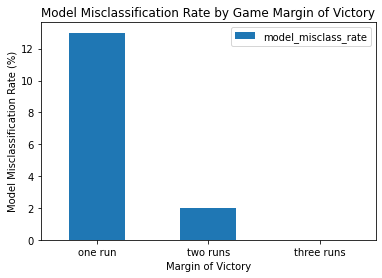

In [209]:
df.plot(kind = "bar");
plt.xlabel("Margin of Victory")
plt.ylabel("Model Misclassification Rate (%)")
plt.xticks(rotation = "horizontal")
plt.title("Model Misclassification Rate by Game Margin of Victory");
plt.savefig("../capstone/images/misclass_rate_by_game_marg_victory.png")

The model had a harder time accurately classifying close games:
- The model misclassified 13% of the games that had a one-run margin of victory for either team, 2% of games with a two run margin of victory, and 0% of the games in which either team won by three runs. 

# Pickling the logistic regression model 2, logreg_home, for StreamLit app

In [121]:
type(logreg_home)

sklearn.linear_model._logistic.LogisticRegression

In [122]:
with open('../capstone/models/logreg_home.pkl', 'wb') as f:
    pickle.dump(logreg_home, f)